#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## BTC Morning Trend Trading Strategy:

This strategy seeks to exploit BTC's behavior to continue following certain upward or downward trends established in the mornings. It uses ordinary least square linear regression to estimate the strength of the trend (by evaluating the slope of the regression line). If the slope is beyond a chosen positive / negative threshold, a long / short is put on. 

Profits are taken after a 4% return and stop losses are hit after a 2% decrease. These parameters will be optimized and can also be improved to be dynamic (vs being static throughout the whole trading window of the strategy). 

If there is no profit taking or stop loss, a position is closed out end of the same day. 

The thresholds for the slope, the morning time window used to evaluate the slope, the profit taking and stop loss levels, and the time limit on an open position can all be optimized within reasonable parameter spaces for the best trading result. 

To determine the robustness of this strategy, Combinatorial Purged Cross Validation is utilized. More on this methodology can be found in the notebook of the same name. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
%matplotlib inline

import optuna
import empyrical
import pyfolio

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
df = pd.read_csv('btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [5]:
#df.index = df.index.tz_localize('UTC')

In [22]:
df.tail()

,close,high,low,open,volume
2020-08-05 23:55:00+00:00,11756.0,11765.0,11755.5,11765.0,31.603704
2020-08-05 23:56:00+00:00,11755.5,11756.0,11755.5,11756.0,36.213357
2020-08-05 23:57:00+00:00,11750.5,11756.0,11750.0,11756.0,75.184964
2020-08-05 23:58:00+00:00,11753.5,11755.5,11750.0,11750.5,49.095172
2020-08-05 23:59:00+00:00,11762.5,11763.0,11753.5,11753.5,109.274824


In [7]:
# helper function that calculates the slope of the best fit linear regression line for the given price series

def OLS_slope_intercept(series):
    # expect 'series' to be a pandas Series
    from sklearn.linear_model import LinearRegression
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.to_numpy().reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0,0], reg.intercept_[0]

### Explore a little

In [34]:
df_linreg = df[(df.index.hour>=3)&(df.index.hour<8)].loc[:'2019-12-31']

slope:  0.8245602728919208


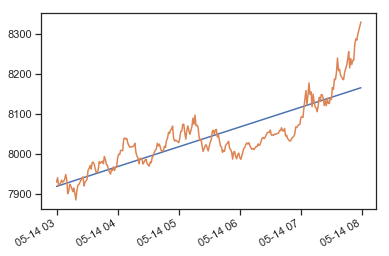

In [41]:
# change dates to look at the chosen window on different days

test_df = df_linreg.loc['2019-05-14':'2019-05-14'].close.copy()
a, b = OLS_slope_intercept(test_df)
y = a*np.arange(len(test_df)) + b
plt.plot(test_df.index,y)
test_df.plot()
print('slope: ', a)

In [8]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [9]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [10]:
# helper function to process the input data frame to make it compatible with the strategy function
# basically it makes sure the given data frame includes complete data for every trading day

def data_process_for_morning_trend(data, eh, em):
    import datetime
    end = datetime.time(eh, em)    
    data_start = datetime.time(data.index[0].hour, data.index[0].minute)
    if data_start > end:
        data_start = data.index.date[0] + datetime.timedelta(seconds=86400)
    else:
        data_start = str(data.index.date[0])
    temp = data.index.date[-1] - datetime.timedelta(seconds=86400)
    if data.index[-1].hour == 23 and data.index[-1].minute == 59:
        data_end = data.index[-1].tz_localize(None)
    else:
        data_end = datetime.datetime(temp.year, temp.month, temp.day, 23, 59)
    return data.loc[data_start:data_end].copy()

In [11]:
# helper function that returns number of paths for given number of groups and test sets

def get_num_paths(num_groups: int, num_tests: int) -> int:
    from scipy.special import comb
    return int(comb(num_groups, num_groups - num_tests) * num_tests / num_groups)

In [12]:
# return the group numbers for test sets as well as the corresponding assigned path for each test set
# depends on implementation of itertools' combinations 
# and thus might not be the most rigorous method for path assignment
# Might be incorrect if itertools' combinations changes behavior

def cpcv_split(num_groups: int, num_tests: int):
    from itertools import combinations
    df = pd.DataFrame(columns=['G'+str(i) for i in range(1,num_groups+1,1)])
    c = list(combinations(range(1,num_groups+1,1), num_tests))
    for i in range(len(c)):
        df = df.append(pd.Series(data=c[i],index=['G'+str(j) for j in c[i]], name='S'+str(i+1)))
    df = df.fillna(0)
    return df.astype('int'), (df!=0).cumsum(axis=0)[df!=0].fillna(0).astype('int')

In [13]:
# helper function that get individual trades' PnL's from cumRet

def rets_from_cumrets(cumRet):
    rets = (cumRet/cumRet.shift(1)-1).dropna()
    return rets[rets!=0]

In [14]:
# helper function that returns cummulative returns from individual trades' returns

def cumRet_from_rets(rets):
    return (rets+1).cumprod()

In [15]:
# maximize PROM + max drawdown to find parameters that yield strategies with reasonable max drawdown 
# and high porportion of positive trades (versus strategies with a few big wins)
# many parameters to optimize but only a few options are available for each parameter space

def cv_obj(trial, data_list):
    sh = int(trial.suggest_discrete_uniform('start_hour', 6, 7, 1))
    sm = int(trial.suggest_discrete_uniform('start_min', 0, 45, 15))
    eh = int(trial.suggest_discrete_uniform('end_hour', 9, 10, 1))
    em = int(trial.suggest_discrete_uniform('end_min', 0, 45, 15))
    su = trial.suggest_discrete_uniform('slope_up', .3, .6, .1)
    sd = trial.suggest_discrete_uniform('slope_down', -.6, -.3, .1)
    pct = trial.suggest_discrete_uniform('pc_threshold', .03, .05, .005)
    pt = trial.suggest_discrete_uniform('profit_taking', .04, .06, .005)
    sl = trial.suggest_discrete_uniform('stop_loss', -.03, -.015, .005)
    return morning_trend_for_cpcv(data_list, sh, sm, eh, em, su, sd, pct, pt, sl)[1]

In [28]:
# function that codes up the strategy 
# also compatible with the CPCV process that follows

def morning_trend_for_cpcv(data_list, start_hour=5, start_min=0, end_hour=8, end_min=30, 
                  slope_up=.4, slope_down=-.4, price_change_theshold=.04,
                  pt = .04, sl = -.015):
    
    # time window used each day to generate signals
    import datetime
    start = datetime.time(start_hour, start_min)
    end = datetime.time(end_hour, end_min)
    
    # run the command below to make sure data's time range is compatible with the rest of this function
    # takes about 350 ms for a year worth of minute data
    data = []
    for df in data_list: 
        data.append(data_process_for_morning_trend(df, end_hour, end_min))
    data = pd.concat(data)
           
    df_linreg = data[(data.index.time>=start)&(data.index.time<end)]
    
    # the last prices of the window used to generate signals for each day in the time period being examined
    # these last prices are where positions were filled if put on
    close = df_linreg.close.resample('1D').last().dropna()  # dropna is needed for when CPCV is used 
    
    # max % price change during the signal-generating time window for each day
    # if price already moved beyond this level, there might not be much left to exploit that particular day
    # again dropna to be compatible with CPCV process
    prct_change = df_linreg.close.resample('1D').apply(lambda x: (x.max()-x.min())/x.min()).dropna()
    
    # slope from the OLS regression line for the time window being examined each day
    slopes = df_linreg.resample('1D').close.apply(lambda x: OLS_slope_intercept(x)[0]
                                                  if not (pd.isna(x)).all() else np.nan).dropna()
    
    # signals for when to put on positions
    signal_long = (slopes>slope_up)&(prct_change<price_change_theshold)
    signal_short = (slopes<slope_down)&(prct_change<price_change_theshold)
    
    # prices where positions were put on
    long_prices = close[signal_long]
    short_prices = close[signal_short]
    
    # data for the rest of each day for the period being examined
    df_test = data[(data.index.time>=end)]
    
    # prices for the rest of each day for the period being examined
    mins = datetime.datetime(2020,1,2,0,0) - datetime.datetime(2020,1,1,end_hour,end_min)
    mins = int(mins.seconds/60)
    df_close = df_test.close.to_numpy().reshape(int(df_test.shape[0]/mins),mins)
    df_close = df_close[:signal_long.shape[0],:]
    
    # prices for the rest of each of the days that had positions on
    long_close = df_close[signal_long]
    short_close = df_close[signal_short]
    
    # booleans that return whether/where there were profit takings or stop losses for longs and shorts
    long_pt = long_close/(long_prices.to_numpy().reshape(long_prices.shape[0],1)*(1+pt))>1
    long_sl = long_close/(long_prices.to_numpy().reshape(long_prices.shape[0],1)*(1+sl))<1
    short_pt = (short_prices.to_numpy().reshape(short_prices.shape[0],1)*(1-pt))/short_close>1
    short_sl = (short_prices.to_numpy().reshape(short_prices.shape[0],1)*(1-sl))/short_close<1
    
    # booleans that return BOTH when/whether pt and sl happened for longs and shorts
    long_ptsl = long_pt | long_sl
    short_ptsl = short_pt | short_sl
    
    # indices where profit takings or stop losses or end of day closings happened, whichever came first
    long_ptsl = np.argmax(long_ptsl, axis=1)
    long_ptsl[long_ptsl==0] = long_pt.shape[1]-1   # if no profit taking or stop loss, close at end of day
    short_ptsl = np.argmax(short_ptsl, axis=1)
    short_ptsl[short_ptsl==0] = short_pt.shape[1]-1 # if no profit taking or stop loss, close at end of day
    
    # returns for longs and shorts
    rets_long = long_close[np.arange(long_pt.shape[0]),long_ptsl]
    rets_short = short_close[np.arange(short_pt.shape[0]),short_ptsl]
    rets_long = rets_long/long_prices-1
    rets_short = short_prices/rets_short-1
    print('longs: ', rets_long.shape[0], '   shorts: ', rets_short.shape[0])
    
    # returns for the strategy
    returns = pd.concat([rets_long, rets_short]).sort_index()
    cumRet = (returns+1).cumprod()    
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))

In [17]:
# function to cross validate using the Combinatorial Purged Cross Validation technique
# with a few minor tweaks can be used for other strategies

def cpcv_morning_trend_strategy(data, objective, num_groups=5, num_tests=2, num_trials=10):
    import optuna
    from datetime import timedelta
    
    # get the splits and paths
    assignment, paths = cpcv_split(num_groups, num_tests)
    numPaths = get_num_paths(num_groups, num_tests)
    
    # store returns for every path
    returns = [pd.Series(dtype='float16') for i in range(numPaths)] 

    # loop through every split
    for i in range(assignment.shape[0]):
        asg = assignment.iloc[i][assignment.iloc[i]!=0]   # the test groups for this split
        path = paths.iloc[i][paths.iloc[i]!=0]   # the corresponding path for each test group in this split
        group_size = int(data.shape[0]/num_groups)   # size of each group
        print('\n\ntest sets: ', asg.values, '    path: ', path.values)

        # split out test set and train set from the given data frame
        # modified a little here from the version for Mixed Bollinger strategy to accommodate
        # the particularity of this strategy. Specificaly:
        # test_sets will be kept as a list of data frames, to be processed in the strategy function
        # same for train_sets
        test_sets = []   
        test_indices = []
        train_sets = []
        train_indices = []
        train_asg = [i for i in range(1, num_groups+1, 1)]
        for i in range(len(asg)):
            train_asg.remove(asg[i])
            start = group_size*(asg[i]-1)
            end = group_size*asg[i]
            print('start: ', start, ' , end: ', end)
            test_sets.append(data.iloc[start:end])
            if end == data.shape[0]:
                end -= 1
            test_indices.append((data.index[start], data.index[end]))
        for i in range(len(train_asg)):
            start = group_size*(train_asg[i]-1)
            end = group_size*train_asg[i]
            train_sets.append(data.iloc[start:end])
        
        # optimize strategy on train sets using Optuna package
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, train_sets), n_trials=num_trials)
        params = study.best_params
        print(asg.values, ': ', params, ' with best value: ', study.best_value)

        # run strategy on test sets
        cr_test = morning_trend_for_cpcv(test_sets, int(params['start_hour']), int(params['start_min']), 
            int(params['end_hour']), int(params['end_min']), params['slope_up'], params['slope_down'],
            params['pc_threshold'], params['profit_taking'], params['stop_loss'])[0]

        # assign test returns to the corresponding paths
        for i in range(len(path)):
            start = test_indices[i][0]
            end = test_indices[i][1]-timedelta(minutes=1)
            rets = rets_from_cumrets(cr_test.loc[start:end])
            print('start: ', start, ' , end: ', end)
            returns[path[i]-1] = pd.concat([returns[path[i]-1], rets])
                                            
    return returns

In [25]:
returns_cv = cpcv_morning_trend_strategy(df, cv_obj, 6, 2, 50)



test sets:  [1 2]     path:  [1 1]
start:  0  , end:  139920
start:  139920  , end:  279840
longs:  14    shorts:  36
longs:  54    shorts:  19
longs:  55    shorts:  59
longs:  47    shorts:  83
longs:  74    shorts:  85
longs:  39    shorts:  27
longs:  49    shorts:  39
longs:  40    shorts:  49
longs:  29    shorts:  69
longs:  61    shorts:  61
longs:  43    shorts:  24
longs:  27    shorts:  25
longs:  40    shorts:  45
longs:  36    shorts:  27
longs:  20    shorts:  38
longs:  46    shorts:  39
longs:  34    shorts:  51
longs:  65    shorts:  24
longs:  40    shorts:  33
longs:  14    shorts:  50
longs:  36    shorts:  47
longs:  40    shorts:  33
longs:  39    shorts:  30
longs:  55    shorts:  23
longs:  62    shorts:  24
longs:  54    shorts:  19
longs:  54    shorts:  19
longs:  56    shorts:  20
longs:  56    shorts:  24
longs:  40    shorts:  9
longs:  52    shorts:  24
longs:  52    shorts:  24
longs:  52    shorts:  24
longs:  52    shorts:  24
longs:  52    shorts:  

longs:  18    shorts:  20
longs:  36    shorts:  37
longs:  30    shorts:  13
longs:  31    shorts:  12
longs:  31    shorts:  12
longs:  31    shorts:  12
longs:  31    shorts:  19
longs:  31    shorts:  19
longs:  31    shorts:  19
longs:  32    shorts:  11
longs:  37    shorts:  29
longs:  20    shorts:  19
longs:  18    shorts:  26
longs:  31    shorts:  19
longs:  31    shorts:  19
longs:  31    shorts:  19
longs:  34    shorts:  23
longs:  19    shorts:  17
longs:  34    shorts:  23
longs:  20    shorts:  15
longs:  34    shorts:  35
longs:  31    shorts:  12
longs:  22    shorts:  19
longs:  21    shorts:  36
longs:  21    shorts:  36
longs:  29    shorts:  41
longs:  29    shorts:  33
longs:  29    shorts:  33
longs:  29    shorts:  33
longs:  33    shorts:  27
longs:  19    shorts:  33
longs:  42    shorts:  34
longs:  20    shorts:  25
longs:  35    shorts:  36
longs:  29    shorts:  33
longs:  29    shorts:  33
longs:  29    shorts:  33
longs:  24    shorts:  29
longs:  21  

In [26]:
cumRets = []
for i in range(len(returns_cv)):
    cumRets.append(cumRet_from_rets(returns_cv[i]))

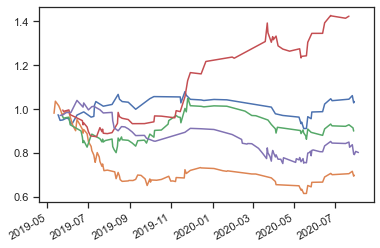

In [27]:
for i in range(len(cumRets)):
    cumRets[i].plot()

In [39]:
returns_cv2 = cpcv_morning_trend_strategy(df, cv_obj, 8, 3, 20)



test sets:  [1 2 3]     path:  [1 1 1]
start:  0  , end:  104940
start:  104940  , end:  209880
start:  209880  , end:  314820
longs:  70    shorts:  55
longs:  29    shorts:  43
longs:  55    shorts:  46
longs:  30    shorts:  17
longs:  50    shorts:  14
longs:  8    shorts:  38
longs:  23    shorts:  66
longs:  18    shorts:  22
longs:  42    shorts:  18
longs:  67    shorts:  46
longs:  21    shorts:  11
longs:  21    shorts:  11
longs:  21    shorts:  11
longs:  10    shorts:  11
longs:  10    shorts:  21
longs:  11    shorts:  15
longs:  35    shorts:  24
longs:  11    shorts:  28
longs:  23    shorts:  18
longs:  17    shorts:  28
[1 2 3] :  {'start_hour': 6.0, 'start_min': 45.0, 'end_hour': 10.0, 'end_min': 30.0, 'slope_up': 0.6, 'slope_down': -0.6, 'pc_threshold': 0.034999999999999996, 'profit_taking': 0.055, 'stop_loss': -0.019999999999999997}  with best value:  0.029168364630451214
longs:  6    shorts:  7
start:  2019-01-01 00:00:00+00:00  , end:  2019-03-14 20:59:00+00:00

longs:  42    shorts:  39
longs:  59    shorts:  32
longs:  32    shorts:  40
longs:  45    shorts:  32
longs:  33    shorts:  33
[1 4 8] :  {'start_hour': 6.0, 'start_min': 0.0, 'end_hour': 9.0, 'end_min': 0.0, 'slope_up': 0.3, 'slope_down': -0.39999999999999997, 'pc_threshold': 0.04, 'profit_taking': 0.04, 'stop_loss': -0.019999999999999997}  with best value:  -0.0710411602606322
longs:  25    shorts:  14
start:  2019-01-01 00:00:00+00:00  , end:  2019-03-14 20:59:00+00:00
start:  2019-08-07 15:00:00+00:00  , end:  2019-10-19 11:59:00+00:00
start:  2020-05-25 03:00:00+00:00  , end:  2020-08-05 23:58:00+00:00


test sets:  [1 5 6]     path:  [16  4  4]
start:  0  , end:  104940
start:  419760  , end:  524700
start:  524700  , end:  629640
longs:  29    shorts:  17
longs:  42    shorts:  21
longs:  61    shorts:  44
longs:  42    shorts:  80
longs:  56    shorts:  45
longs:  59    shorts:  54
longs:  9    shorts:  10
longs:  29    shorts:  32
longs:  50    shorts:  72
longs:  44    sho

start:  2019-03-14 21:00:00+00:00  , end:  2019-05-26 17:59:00+00:00
start:  2019-08-07 15:00:00+00:00  , end:  2019-10-19 11:59:00+00:00
start:  2020-03-13 06:00:00+00:00  , end:  2020-05-25 02:59:00+00:00


test sets:  [2 4 8]     path:  [15 11  8]
start:  104940  , end:  209880
start:  314820  , end:  419760
start:  734580  , end:  839520
longs:  14    shorts:  51
longs:  43    shorts:  16
longs:  30    shorts:  48
longs:  19    shorts:  42
longs:  23    shorts:  30
longs:  37    shorts:  24
longs:  17    shorts:  20
longs:  52    shorts:  47
longs:  62    shorts:  60
longs:  40    shorts:  15
longs:  21    shorts:  41
longs:  29    shorts:  18
longs:  37    shorts:  38
longs:  33    shorts:  28
longs:  37    shorts:  27
longs:  38    shorts:  25
longs:  18    shorts:  24
longs:  29    shorts:  27
longs:  37    shorts:  24
longs:  33    shorts:  38
[2 4 8] :  {'start_hour': 6.0, 'start_min': 15.0, 'end_hour': 9.0, 'end_min': 15.0, 'slope_up': 0.4, 'slope_down': -0.5, 'pc_threshold':

longs:  40    shorts:  21
longs:  8    shorts:  9
longs:  6    shorts:  14
longs:  17    shorts:  10
longs:  32    shorts:  7
longs:  36    shorts:  17
longs:  25    shorts:  9
longs:  27    shorts:  11
longs:  28    shorts:  22
longs:  42    shorts:  21
[3 6 7] :  {'start_hour': 6.0, 'start_min': 0.0, 'end_hour': 10.0, 'end_min': 15.0, 'slope_up': 0.4, 'slope_down': -0.6, 'pc_threshold': 0.045, 'profit_taking': 0.045, 'stop_loss': -0.024999999999999998}  with best value:  0.20042073253302903
longs:  22    shorts:  13
start:  2019-05-26 18:00:00+00:00  , end:  2019-08-07 14:59:00+00:00
start:  2019-12-31 09:00:00+00:00  , end:  2020-03-13 05:59:00+00:00
start:  2020-03-13 06:00:00+00:00  , end:  2020-05-25 02:59:00+00:00


test sets:  [3 6 8]     path:  [20 15 14]
start:  209880  , end:  314820
start:  524700  , end:  629640
start:  734580  , end:  839520
longs:  42    shorts:  74
longs:  50    shorts:  47
longs:  43    shorts:  30
longs:  20    shorts:  33
longs:  51    shorts:  36
lo

In [40]:
cumRets2 = []
for i in range(len(returns_cv2)):
    cumRets2.append(cumRet_from_rets(returns_cv2[i]))

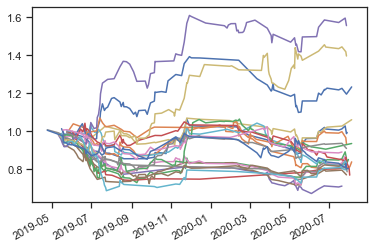

In [44]:
for i in range(len(cumRets2)):
    cumRets2[i].plot()

In [45]:
returns_cv3 = cpcv_morning_trend_strategy(df, cv_obj, 8, 3, 50)



test sets:  [1 2 3]     path:  [1 1 1]
start:  0  , end:  104940
start:  104940  , end:  209880
start:  209880  , end:  314820
longs:  38    shorts:  44
longs:  7    shorts:  23
longs:  16    shorts:  61
longs:  46    shorts:  21
longs:  40    shorts:  31
longs:  47    shorts:  38
longs:  59    shorts:  37
longs:  38    shorts:  89
longs:  16    shorts:  20
longs:  14    shorts:  31
longs:  31    shorts:  46
longs:  31    shorts:  46
longs:  31    shorts:  46
longs:  34    shorts:  57
longs:  43    shorts:  34
longs:  43    shorts:  34
longs:  42    shorts:  36
longs:  54    shorts:  29
longs:  41    shorts:  30
longs:  45    shorts:  27
longs:  56    shorts:  30
longs:  31    shorts:  30
longs:  42    shorts:  30
longs:  39    shorts:  29
longs:  42    shorts:  21
longs:  40    shorts:  18
longs:  61    shorts:  21
longs:  37    shorts:  17
longs:  37    shorts:  17
longs:  53    shorts:  17
longs:  48    shorts:  13
longs:  53    shorts:  17
longs:  53    shorts:  17
longs:  53    

longs:  49    shorts:  23
longs:  17    shorts:  11
longs:  19    shorts:  17
longs:  12    shorts:  15
longs:  15    shorts:  21
longs:  33    shorts:  20
longs:  12    shorts:  14
longs:  26    shorts:  21
longs:  24    shorts:  20
longs:  29    shorts:  36
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  41    shorts:  32
longs:  38    shorts:  32
longs:  73    shorts:  46
longs:  51    shorts:  28
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  21
longs:  38    shorts:  32
longs:  38    shorts:  21
longs:  42    shorts:  37
longs:  49    shorts:  26
longs:  44    shorts:  20
[1 2 7] :  {'start_hour': 6.0, 'start_min': 0.0, 'end_hour': 10.0, 'end_min': 15.0, 'slope_up': 0.3, 'slope_down': -0.5, 'pc_threshold': 0.04, 'profit_taking': 0.05, 'stop_loss': -0.024999999999999998}  with best value: 

test sets:  [1 4 7]     path:  [14  5  3]
start:  0  , end:  104940
start:  314820  , end:  419760
start:  629640  , end:  734580
longs:  46    shorts:  50
longs:  26    shorts:  63
longs:  59    shorts:  87
longs:  54    shorts:  31
longs:  51    shorts:  23
longs:  53    shorts:  58
longs:  23    shorts:  46
longs:  55    shorts:  65
longs:  77    shorts:  80
longs:  42    shorts:  20
longs:  31    shorts:  19
longs:  31    shorts:  19
longs:  29    shorts:  21
longs:  34    shorts:  18
longs:  32    shorts:  21
longs:  22    shorts:  19
longs:  29    shorts:  32
longs:  17    shorts:  29
longs:  29    shorts:  15
longs:  12    shorts:  11
longs:  13    shorts:  22
longs:  13    shorts:  22
longs:  13    shorts:  32
longs:  9    shorts:  11
longs:  11    shorts:  15
longs:  9    shorts:  12
longs:  11    shorts:  15
longs:  15    shorts:  15
longs:  13    shorts:  16
longs:  17    shorts:  12
longs:  15    shorts:  11
longs:  12    shorts:  11
longs:  12    shorts:  11
longs:  17    

longs:  63    shorts:  47
longs:  38    shorts:  28
longs:  43    shorts:  36
longs:  45    shorts:  36
longs:  45    shorts:  36
longs:  45    shorts:  36
longs:  47    shorts:  36
longs:  45    shorts:  36
longs:  43    shorts:  24
longs:  51    shorts:  40
longs:  45    shorts:  45
[2 3 4] :  {'start_hour': 7.0, 'start_min': 45.0, 'end_hour': 10.0, 'end_min': 45.0, 'slope_up': 0.3, 'slope_down': -0.3, 'pc_threshold': 0.04, 'profit_taking': 0.045, 'stop_loss': -0.015}  with best value:  0.11577942228313183
longs:  34    shorts:  35
start:  2019-03-14 21:00:00+00:00  , end:  2019-05-26 17:59:00+00:00
start:  2019-05-26 18:00:00+00:00  , end:  2019-08-07 14:59:00+00:00
start:  2019-08-07 15:00:00+00:00  , end:  2019-10-19 11:59:00+00:00


test sets:  [2 3 5]     path:  [8 8 7]
start:  104940  , end:  209880
start:  209880  , end:  314820
start:  419760  , end:  524700
longs:  43    shorts:  59
longs:  35    shorts:  42
longs:  11    shorts:  15
longs:  50    shorts:  54
longs:  22    s

longs:  42    shorts:  30
longs:  43    shorts:  34
longs:  42    shorts:  30
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  30    shorts:  23
longs:  42    shorts:  16
longs:  59    shorts:  32
longs:  27    shorts:  25
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  51    shorts:  28
longs:  37    shorts:  22
longs:  43    shorts:  34
longs:  23    shorts:  21
longs:  47    shorts:  20
longs:  38    shorts:  26
longs:  23    shorts:  21
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  42    shorts:  25
longs:  55    shorts:  30
longs:  47    shorts:  20
longs:  46    shorts:  41
longs:  38    shorts:  19
longs:  54    shorts:  29
longs:  26    shorts:  15
longs:  23    shorts:  16
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  39    shorts:  21
longs:  37    shorts:  20
longs:  31    shorts:  22
longs:  37    shorts:  20
longs:  58    shorts:  29
longs:  40    shorts:  29
longs:  21  

longs:  25    shorts:  18
start:  2019-05-26 18:00:00+00:00  , end:  2019-08-07 14:59:00+00:00
start:  2019-08-07 15:00:00+00:00  , end:  2019-10-19 11:59:00+00:00
start:  2020-03-13 06:00:00+00:00  , end:  2020-05-25 02:59:00+00:00


test sets:  [3 4 8]     path:  [15 15 12]
start:  209880  , end:  314820
start:  314820  , end:  419760
start:  734580  , end:  839520
longs:  25    shorts:  26
longs:  20    shorts:  44
longs:  6    shorts:  36
longs:  40    shorts:  18
longs:  15    shorts:  36
longs:  28    shorts:  38
longs:  5    shorts:  9
longs:  26    shorts:  13
longs:  41    shorts:  21
longs:  38    shorts:  38
longs:  6    shorts:  21
longs:  6    shorts:  21
longs:  6    shorts:  25
longs:  6    shorts:  25
longs:  10    shorts:  16
longs:  9    shorts:  28
longs:  10    shorts:  8
longs:  7    shorts:  12
longs:  14    shorts:  16
longs:  31    shorts:  8
longs:  8    shorts:  17
longs:  5    shorts:  19
longs:  4    shorts:  6
longs:  6    shorts:  10
longs:  13    shorts: 

longs:  11    shorts:  9
longs:  14    shorts:  26
longs:  26    shorts:  29
longs:  13    shorts:  15
longs:  20    shorts:  28
longs:  11    shorts:  6
longs:  11    shorts:  9
longs:  11    shorts:  9
longs:  11    shorts:  9
longs:  12    shorts:  14
longs:  12    shorts:  10
longs:  19    shorts:  20
longs:  11    shorts:  8
longs:  11    shorts:  9
[4 5 7] :  {'start_hour': 6.0, 'start_min': 0.0, 'end_hour': 10.0, 'end_min': 30.0, 'slope_up': 0.5, 'slope_down': -0.5, 'pc_threshold': 0.034999999999999996, 'profit_taking': 0.055, 'stop_loss': -0.03}  with best value:  -0.03249028983640537
longs:  6    shorts:  10
start:  2019-08-07 15:00:00+00:00  , end:  2019-10-19 11:59:00+00:00
start:  2019-10-19 12:00:00+00:00  , end:  2019-12-31 08:59:00+00:00
start:  2020-03-13 06:00:00+00:00  , end:  2020-05-25 02:59:00+00:00


test sets:  [4 5 8]     path:  [18 18 16]
start:  314820  , end:  419760
start:  419760  , end:  524700
start:  734580  , end:  839520
longs:  18    shorts:  49
longs

In [46]:
cumRets3 = []
for i in range(len(returns_cv3)):
    cumRets3.append(cumRet_from_rets(returns_cv3[i]))

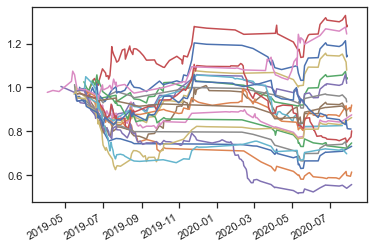

In [47]:
for i in range(len(cumRets3)):
    cumRets3[i].plot()

In [51]:
#import pickle
#pickle.dump( returns_cv, open( "morning_trend_cpcv_6_2_50.pickle", "wb" ))
#pickle.dump( returns_cv, open( "morning_trend_cpcv_8_3_20.pickle", "wb" )) 
#pickle.dump( returns_cv, open( "morning_trend_cpcv_8_3_50.pickle", "wb" )) 